# Setup

In [137]:
%load_ext autoreload
%autoreload 2
%aimport

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Modules to reload:
all-except-skipped

Modules to skip:



In [138]:
%matplotlib inline

In [139]:
import sys
sys.path.append('/home/imendoza/nbody-relaxed/')

import relaxed

In [140]:
# import astropy
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt 
import re 
from astropy.table import Table
import astropy.table
import json
from scipy import stats
from copy import deepcopy
import sklearn
import scipy
import warnings
from tqdm import tqdm

import matplotlib as mpl
from sklearn.model_selection import train_test_split


In [141]:
from relaxed.analysis import get_mah, fit_hearin_params, get_t_from_a, transform_diffmah, alpha_diffmah, diffmah_analysis
from relaxed.models import training_suite, prepare_datasets
from relaxed import halo_catalogs


# Data

In [142]:
mah_data = get_mah('m12', '../../output/', cutoff_missing=0.05, cutoff_particle=0.05)

In [143]:
ma_peak = mah_data['ma_peak']
mpeak =mah_data['mpeak']
scales = mah_data['scales']
t = get_t_from_a(scales)
t0 = get_t_from_a(1)

# Lmfit

In [39]:
tau_c2, alpha_early2, alpha_late2 = diffmah_analysis(ma_peak, scales)

Fitting Diffmah parameters: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [01:07<00:00, 147.96it/s]


[6048 2763 1203 4704 7738 2676 5886 1046 1627]


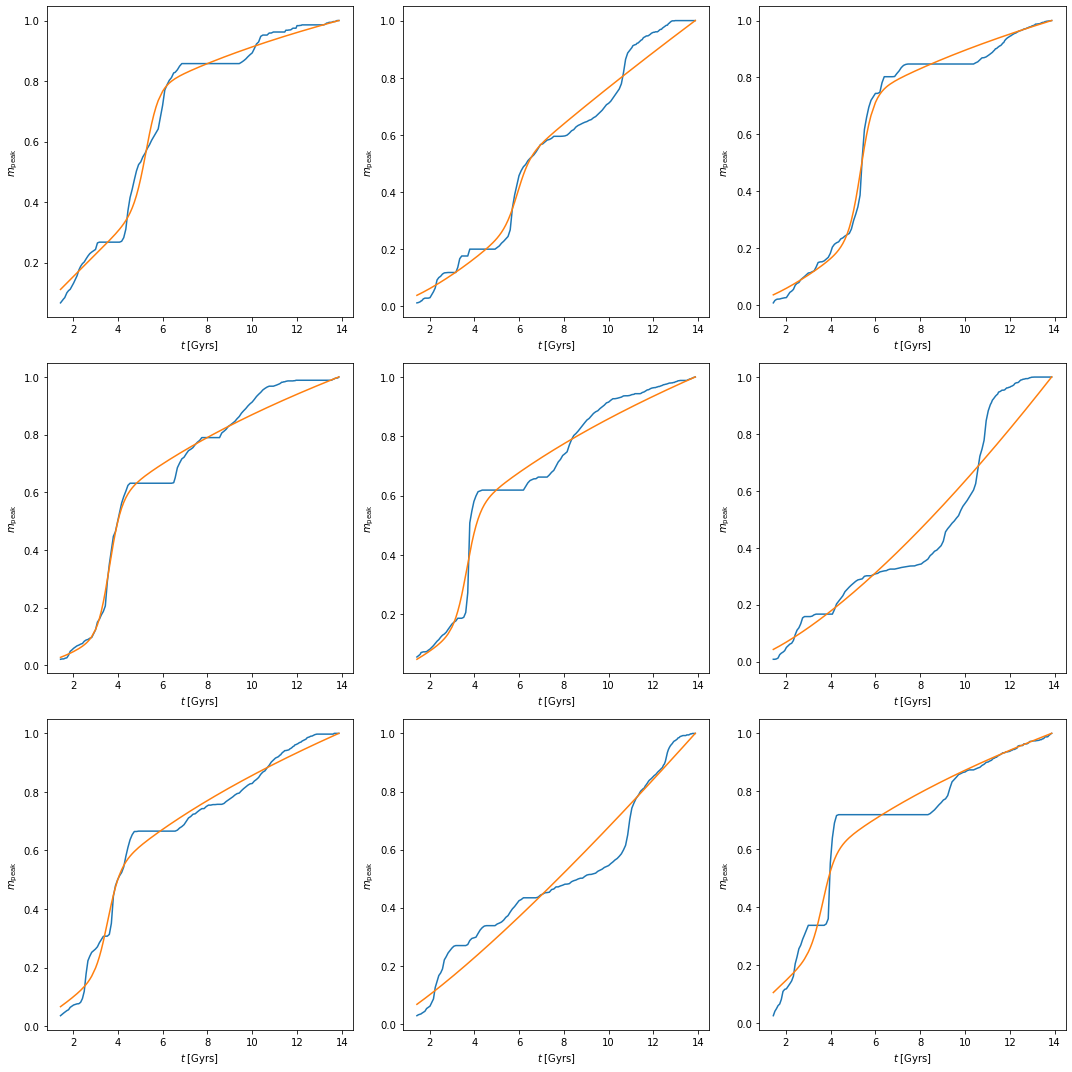

In [16]:
indices = np.random.randint(0, 10000, 9)
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
print(indices)
for idx, ax in zip(indices, axes.flatten()): 
    pred = (t/t0)**(alpha_diffmah(t, tau_c[idx], alpha_early[idx], alpha_late[idx]))
    ax.plot(t, ma_peak[idx])
    ax.plot(t, pred)
    ax.set_xlabel(r"$t \; [\rm Gyrs]$")
    ax.set_ylabel(r"$m_{\rm peak}$")
plt.tight_layout()

Text(0.5, 0, '$\\log \\tau_{c} \\; [\\rm Gyr]$')

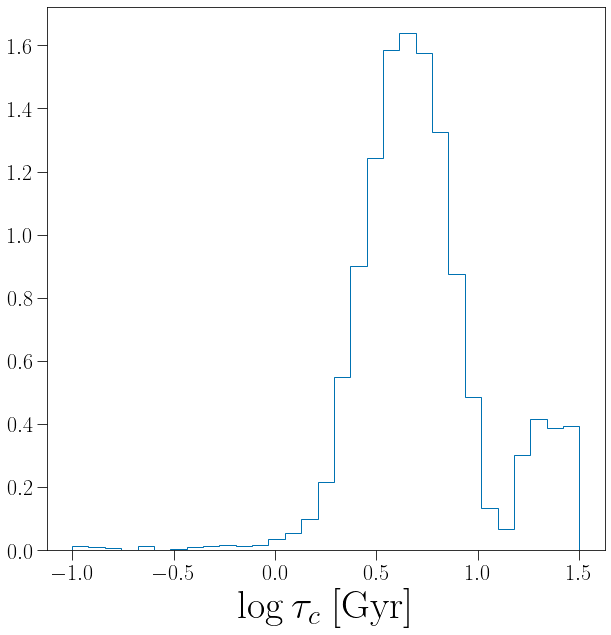

In [51]:
plt.hist(np.log10(tau_c), range=(-1, 1.5), bins=31, density=True, histtype='step')
plt.xlabel(r"$\log \tau_{c} \; [\rm Gyr]$", fontsize=40)

# Diffmah directly

In [46]:
from diffmah.fit_mah_helpers import get_loss_data
from diffmah.fit_mah_helpers import log_mah_mse_loss_and_grads
from diffmah.utils import jax_adam_wrapper
from diffmah.measure_mahs import get_clean_sample_mask

In [48]:
log_mah = np.log10(ma_peak * mpeak.reshape(-1, 1))
log_min_mass = np.log10(100 * 1.35e8)


keep = get_clean_sample_mask(log_mah, log_min_mass, 0, lim=0.01, z_cut=3)
print(sum(keep))

8416


In [95]:
import json


idx = 10
n_steps = 200
lma_i = log_mah[idx, :]
p_init, loss_data = get_loss_data(t, lma_i, log_min_mass)
_res = jax_adam_wrapper(log_mah_mse_loss_and_grads, p_init, loss_data, n_steps, n_warmup=1)
p_best, loss, loss_arr, params_arr, fit_terminates = _res



  0%|▍                                                                                                                                                                             | 26/10000 [00:42<4:29:57,  1.62s/it]


KeyboardInterrupt: 

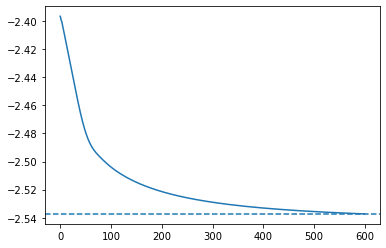

In [128]:
n_steps = 600
lma_i = log_mah[2157, :]
p_init, loss_data = get_loss_data(t, lma_i, log_min_mass)
_res = jax_adam_wrapper(log_mah_mse_loss_and_grads, p_init, loss_data, n_steps, n_warmup=1)
p_best, loss, loss_arr, params_arr, fit_terminates = _res

fig, ax = plt.subplots(1, 1)
__=ax.plot(np.log10(loss_arr))
plt.axhline(min(np.log10(loss_arr)), ls='--')


## Plots

In [148]:
from relaxed.analysis import inv_softplus

In [149]:
# Here we have p_init = (u_logtc_fit, u_early_fit, u_late_fit)
pars = np.load('../../output/pbest_9900.npy')

(array([0.01429868, 0.00794371, 0.00635497, 0.0055606 , 0.01032683,
        0.0166818 , 0.01747617, 0.04527916, 0.14854743, 0.62834775,
        1.19076242, 1.53075361, 1.31071274, 0.65297326, 0.12153877,
        0.24148899, 0.38447558, 0.34078546, 0.21368581, 0.07069908,
        0.04130729]),
 array([-1.        , -0.85714287, -0.71428573, -0.5714286 , -0.42857143,
        -0.2857143 , -0.14285715,  0.        ,  0.14285715,  0.2857143 ,
         0.42857143,  0.5714286 ,  0.71428573,  0.85714287,  1.        ,
         1.1428572 ,  1.2857143 ,  1.4285715 ,  1.5714285 ,  1.7142857 ,
         1.8571428 ,  2.        ], dtype=float32),
 [<matplotlib.patches.Polygon at 0x7fbcec796f90>])

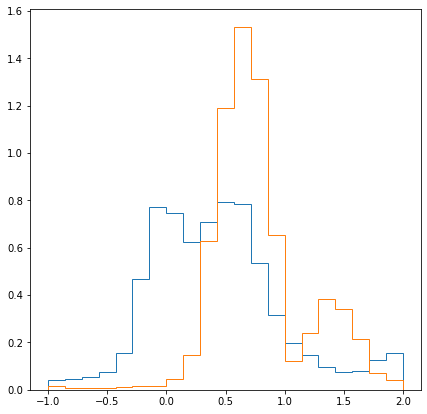

In [150]:
plt.figure(figsize=(7,7))
n, bins, patches = plt.hist(pars[:, 0], histtype='step', bins=21, range=(-1, 2), density=True)
plt.hist(np.log10(tau_c2), bins=bins, range=(-1, 2), histtype='step', density=True)


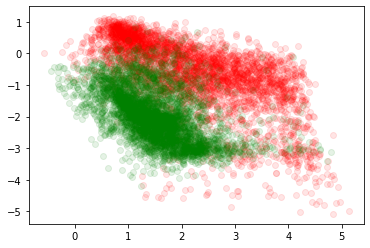

In [147]:
plt.scatter(pars[:, 1][10**pars[:, 0] < 2], pars[:, 2][10**pars[:, 0]< 2], alpha=0.1, color='r')
plt.scatter(pars[:, 1][10**pars[:, 0] > 2], pars[:, 2][10**pars[:, 0]>2], alpha=0.1, color='g')

In [133]:
log_mah = np.log10(ma_peak * mpeak.reshape(-1, 1))
log_min_mass = np.log10(100 * 1.35e8)

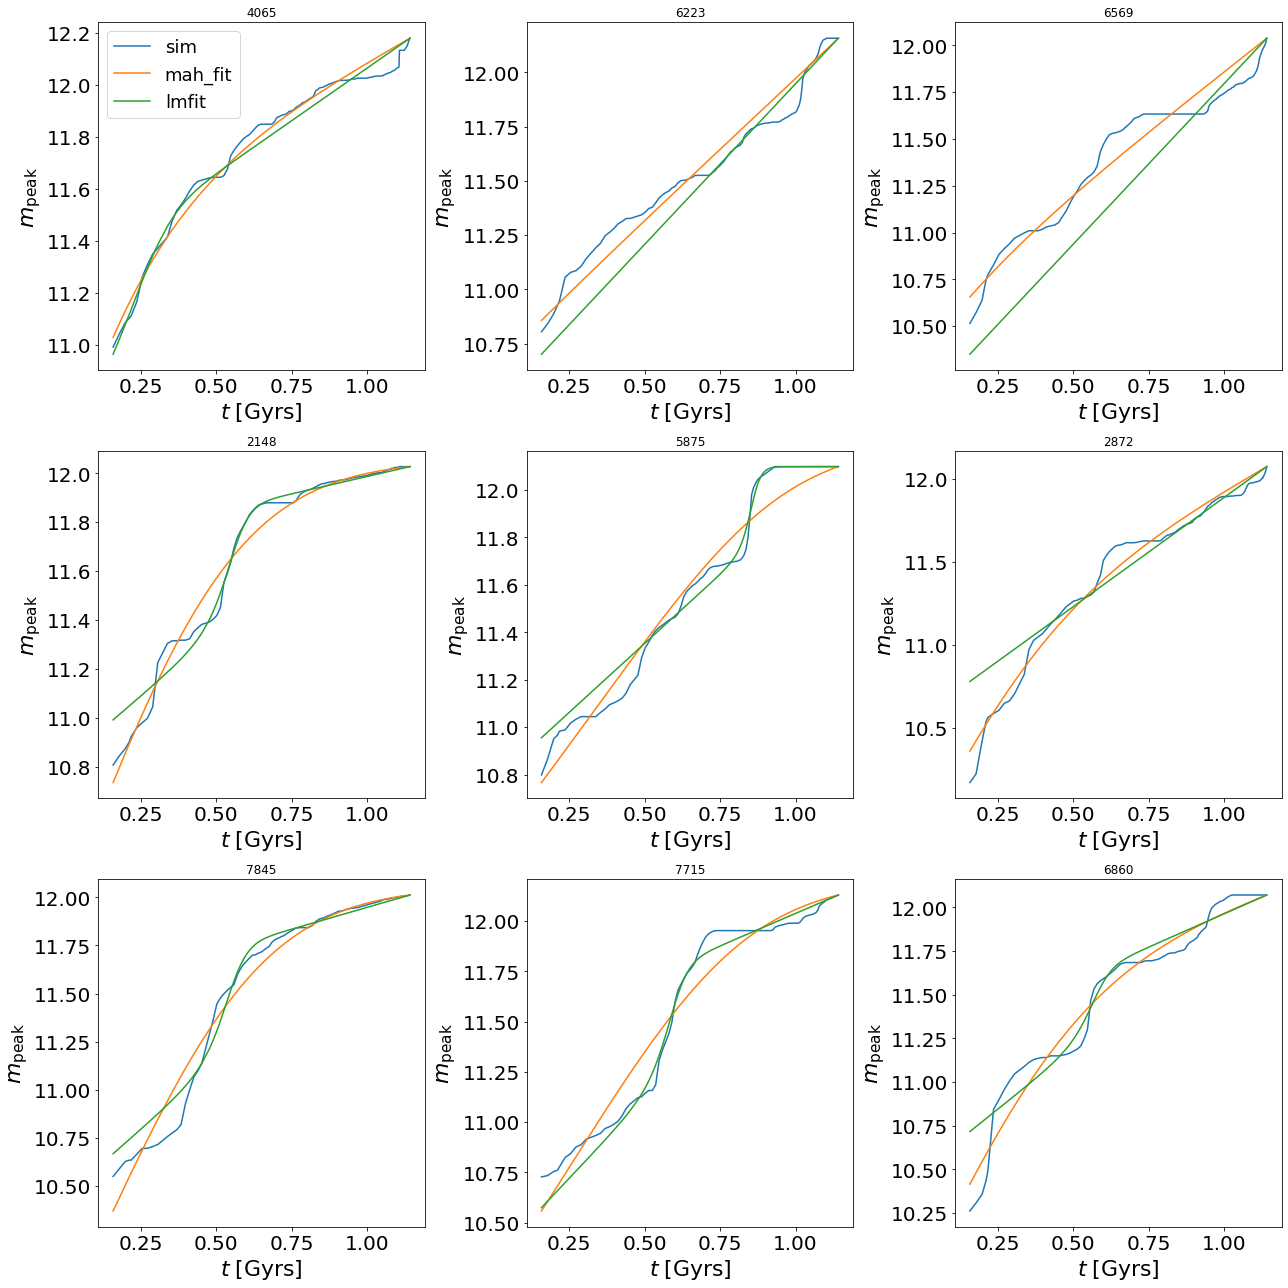

In [135]:
from diffmah.individual_halo_assembly import _get_early_late
from diffmah.individual_halo_assembly import _calc_halo_history


indices = np.random.randint(0, len(pars), 9)
fig, axes = plt.subplots(3, 3, figsize=(18, 18))

for ii, (idx, ax) in enumerate(zip(indices, axes.flatten())):
#     pred = (t/t0)**(alpha_diffmah(t, tc[idx], alpha_early[idx], alpha_late[idx]))
    logtc, ue, ul = pars[idx, 0], pars[idx, 1], pars[idx, 2]
    
    p_init, loss_data = get_loss_data(t, log_mah[idx, :], log_min_mass)
    logt_target, log_mah_target, logtmp, k, logmp_fit = loss_data
    early, late = _get_early_late(ue, ul)

    logt = np.log10(t)
    dmhdt_fit, log_mah_fit = _calc_halo_history(logt, logt[-1], logmp_fit, logtc, 3.5, early, late)

    
    lmfit_log_mah_fit = np.log10((t/t0)**(alpha_diffmah(t, tau_c2[idx], alpha_early2[idx], alpha_late2[idx])) * mpeak[idx])

    
    ax.plot(logt_target, log_mah_target, label='sim')
    ax.plot(logt, log_mah_fit, label='mah_fit')
    ax.plot(logt, lmfit_log_mah_fit, label='lmfit')
    ax.set_xlabel(r"$t \; [\rm Gyrs]$", size=22)
    ax.set_ylabel(r"$m_{\rm peak}$", size=22)
    ax.set_title(idx)
    if ii == 0: 
        ax.legend(prop=dict(size=18), loc='best')
    ax.tick_params(axis='both', labelsize=20)
plt.tight_layout()

